# The Clairvoyant Constructor (rebar)

Insight Week 7 Data Challenge

Gwen Yang
07-19-19

In [276]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
plt.style.use('fivethirtyeight')

## Load data

In [350]:
raw = pd.read_csv("construction_material_prices_2008_2018.csv", index_col=[0], parse_dates=[0])
# raw.head()
raw.info()
# print(raw.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2945 entries, 2007-01-01 to 2018-06-19
Data columns (total 5 columns):
price_steel       2309 non-null float64
price_rebar       1649 non-null float64
price_glass       1472 non-null float64
price_concrete    1447 non-null float64
price_plywood     2673 non-null float64
dtypes: float64(5)
memory usage: 138.0 KB


## Work with rebar

In [351]:
rebar = pd.DataFrame(data= raw.price_rebar, index = raw.index, columns = ['price_rebar'])
rebar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2945 entries, 2007-01-01 to 2018-06-19
Data columns (total 1 columns):
price_rebar    1649 non-null float64
dtypes: float64(1)
memory usage: 46.0 KB


### Initial plot

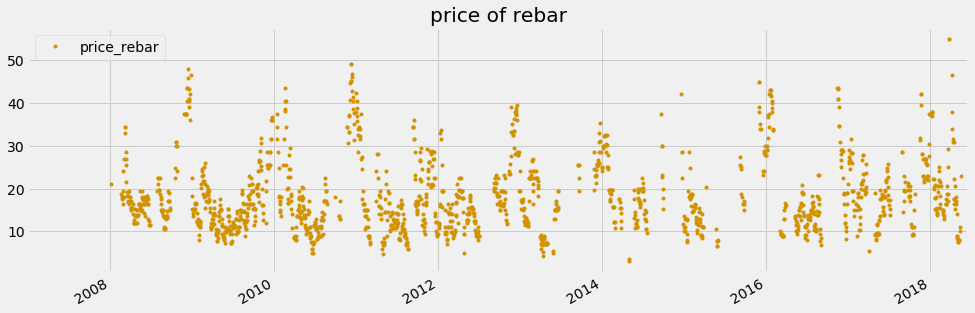

In [341]:
color_pal = [ "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB", "#F8766D"]
rebar.plot(style='.', color=color_pal[0], figsize=(15,5),  title='price of rebar') #color=color_pal[0],

## Data cleanning - Impute missing value

#### Impute with mean

In [344]:
print(rebar.isnull().sum())
rebar.fillna(rebar.mean(),inplace=True)

price_rebar    1296
dtype: int64


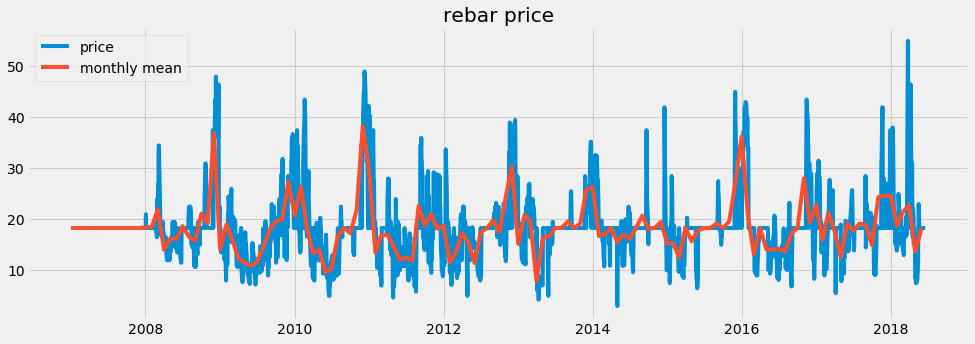

In [345]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.plot(rebar, label='price') 
rebar_M = rebar.resample('MS').mean()
ax.plot(rebar_M, label='monthly mean')
ax.set_title('rebar price')
ax.legend(loc='upper left')

#### Drop missing values

In [352]:
rebar.dropna(inplace=True)

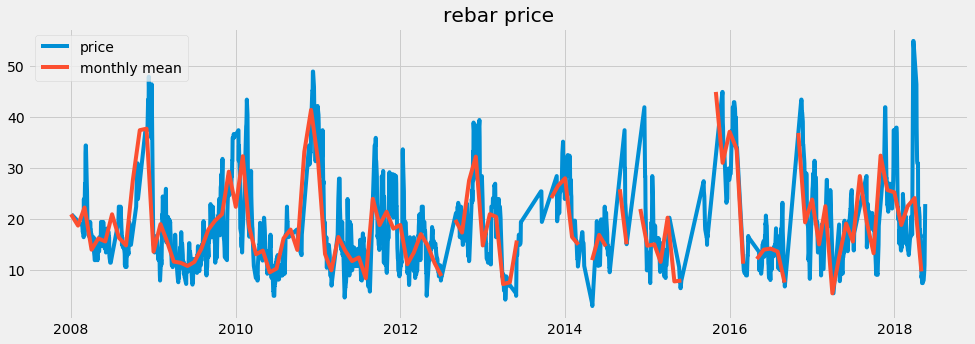

In [353]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.plot(rebar, label='price') 
rebar_M = rebar.resample('MS').mean()
ax.plot(rebar_M, label='monthly mean')
ax.set_title('rebar price')
ax.legend(loc='upper left')

#### Impute with quaterly mean

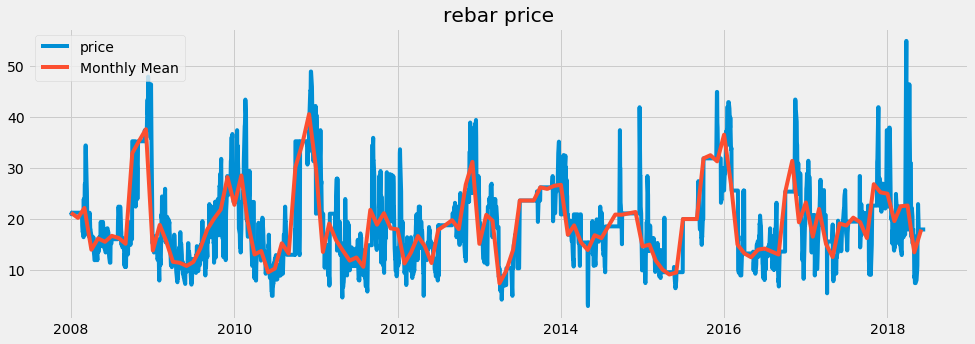

In [303]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
rebar = rebar.resample('QS').transform(lambda x: x.fillna(x.mean()))
ax.plot(rebar, label='price') #color=color_pal[0],   title='price of rebar'
rebar_M = rebar.resample('MS').mean()
ax.plot(rebar_M, label='Monthly Mean')
ax.set_title('rebar price')
ax.set_title('rebar price')
ax.legend(loc='upper left')

## Train/Test Split
Cut off data after 2016 to use as validation set

In [354]:
split_date = '2017-01-01'
rebar_train = rebar.loc[rebar.index <= split_date].copy()
rebar_test = rebar.loc[rebar.index > split_date].copy()

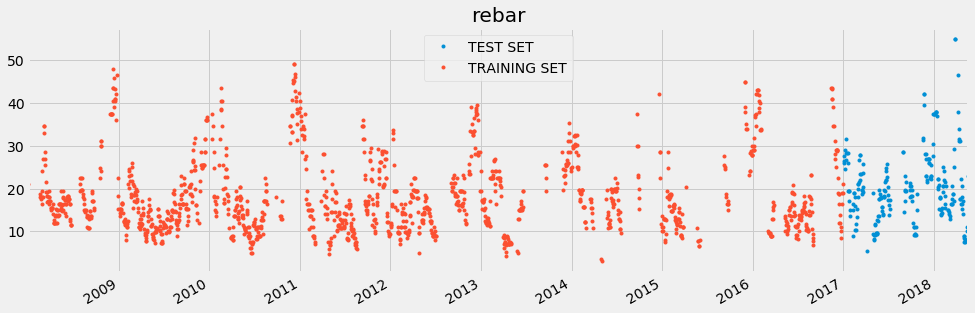

In [355]:
rebar_test \
    .rename(columns={'price_rebar': 'TEST SET'}) \
    .join(rebar_train.rename(columns={'price_rebar': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='rebar', style='.')

## Create Time Series Features

In [316]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df_date = pd.to_datetime(df.index)

    df['year'] = df_date.year
    df['quarter'] = df_date.quarter
    df['month'] = df_date.month
    df['day'] = df_date.day
    df['weekofyear'] = df_date.weekofyear
    df['dayofyear'] = df_date.dayofyear
    

#     df['dayofyear'] = df_date.dayofyear
#     df['dayofmonth'] = df_date.day
   
    X = df[['year','quarter','month','day', 'weekofyear']]

    if label:
        y = df[label]
        return X, y
    return X

In [356]:
X_train, y_train = create_features(rebar_train, label='price_rebar')
X_test, y_test = create_features(rebar_test, label='price_rebar')

## Create XGBoost Model

In [357]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:17.7783	validation_1-rmse:19.402
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:16.2208	validation_1-rmse:17.6173
[2]	validation_0-rmse:14.8444	validation_1-rmse:16.1826
[3]	validation_0-rmse:13.6256	validation_1-rmse:14.8509
[4]	validation_0-rmse:12.5334	validation_1-rmse:13.6946
[5]	validation_0-rmse:11.5845	validation_1-rmse:12.757
[6]	validation_0-rmse:10.7385	validation_1-rmse:12.0528
[7]	validation_0-rmse:9.99812	validation_1-rmse:11.4063
[8]	validation_0-rmse:9.35325	validation_1-rmse:10.8858
[9]	validation_0-rmse:8.79341	validation_1-rmse:10.3847
[10]	validation_0-rmse:8.30989	validation_1-rmse:10.0085
[11]	validation_0-rmse:7.88381	validation_1-rmse:9.66494
[12]	validation_0-rmse:7.51813	validation_1-rmse:9.41508
[13]	validation_0-rmse:7.21073	validation_1-rmse:9.2044
[14]	validation_0-rmse:6.94004	validation_1-rmse:9.01146

/Users/shiningyg/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/shiningyg/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[27]	validation_0-rmse:5.5126	validation_1-rmse:8.50889
[28]	validation_0-rmse:5.45891	validation_1-rmse:8.65302
[29]	validation_0-rmse:5.42114	validation_1-rmse:8.68051
[30]	validation_0-rmse:5.3979	validation_1-rmse:8.67865
[31]	validation_0-rmse:5.3612	validation_1-rmse:8.68877
[32]	validation_0-rmse:5.32394	validation_1-rmse:8.7049
[33]	validation_0-rmse:5.29326	validation_1-rmse:8.75252
[34]	validation_0-rmse:5.27174	validation_1-rmse:8.75515
[35]	validation_0-rmse:5.25347	validation_1-rmse:8.76236
[36]	validation_0-rmse:5.23764	validation_1-rmse:8.74993
[37]	validation_0-rmse:5.21829	validation_1-rmse:8.76781
[38]	validation_0-rmse:5.19955	validation_1-rmse:8.7752
[39]	validation_0-rmse:5.18051	validation_1-rmse:8.77243
[40]	validation_0-rmse:5.15329	validation_1-rmse:8.78868
[41]	validation_0-rmse:5.13261	validation_1-rmse:8.83483
[42]	validation_0-rmse:5.11062	validation_1-rmse:8.84977
[43]	validation_0-rmse:5.0963	validation_1-rmse:8.84449
[44]	validation_0-rmse:5.07795	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

## Feature importance

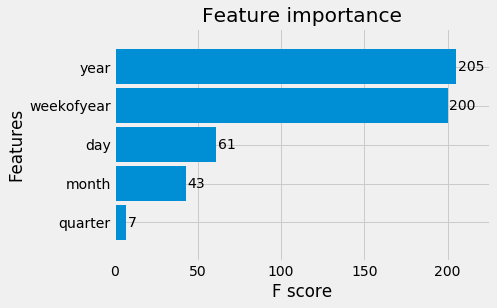

In [358]:
plot_importance(reg, height=0.9)

## Predict on Test Set

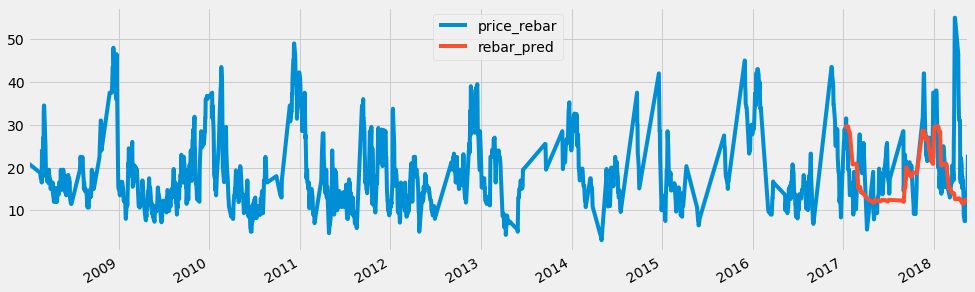

In [362]:
f, ax = plt.subplots(1)
rebar_test['rebar_pred'] = reg.predict(X_test)
rebar_all = pd.concat([rebar_test, rebar_train], sort=False)
rebar_all[['price_rebar','rebar_pred']].plot(figsize=(15, 5), ax= ax)
# ax.set_xbound(lower='07-01-2016', upper='6-19-2018')

In [321]:
rebar_test.head()

,price_rebar,year,quarter,month,day,weekofyear,rebar_pred
2017-01-03,26.0,2017,1,1,3,1,29.575211
2017-01-04,26.5,2017,1,1,4,1,29.575211
2017-01-05,27.5,2017,1,1,5,1,29.575211
2017-01-06,29.0,2017,1,1,6,1,29.575211
2017-01-09,24.5,2017,1,1,9,2,29.575211


## Forecast on future 6 months

In [360]:
# build time index
date_rng = pd.date_range(start='2018-06-20', end='2018-12-31', freq='D')
rebar_fc = pd.DataFrame(index=date_rng)
# print(rebar_fc)
rebar_fc['rebar_pred'] = 0

# df_fc.head()
x_fc, y_fc = create_features(rebar_fc, label='rebar_pred')
# print(x_fc)

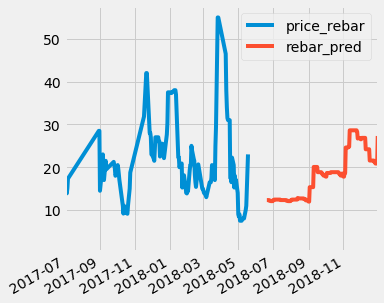

In [361]:
f, ax = plt.subplots(1)
rebar_fc['rebar_pred'] = reg.predict(x_fc)
rebar_all_fc = pd.concat([rebar, rebar_fc], sort=False)
rebar_all_fc[['price_rebar','rebar_pred']].plot(figsize=(5, 5), ax=ax)
ax.set_xbound(lower='07-01-2017', upper='12-31-2018')

In [324]:
print(rebar.tail())

            price_rebar
2018-06-13    18.306339
2018-06-14    18.306339
2018-06-15    18.306339
2018-06-18    18.306339
2018-06-19    18.306339


### Look into prediction details

#### First month  January 2016

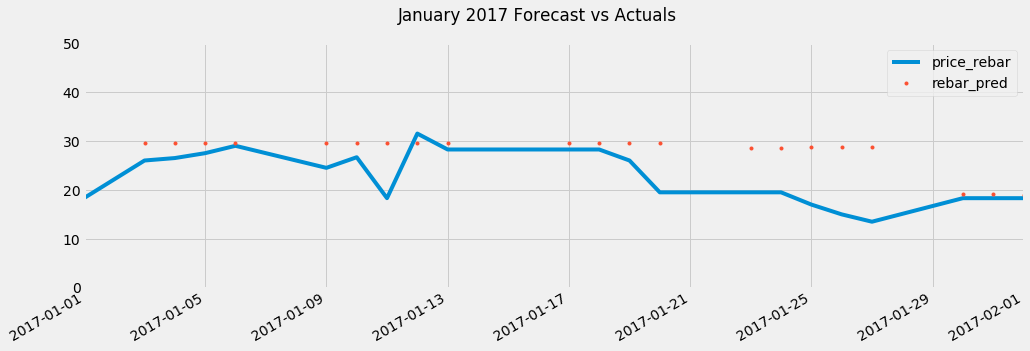

In [330]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
rebar_all[['price_rebar','rebar_pred']].plot(figsize=(15, 5), ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2017', upper='02-01-2017')
ax.set_ylim(0, 50)
plot = plt.suptitle('January 2017 Forecast vs Actuals')

#### First week of 2016

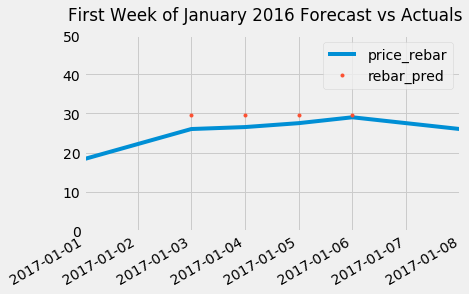

In [331]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
rebar_all[['price_rebar','rebar_pred']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2017', upper='01-08-2017')
ax.set_ylim(0, 50)
plot = plt.suptitle('First Week of January 2016 Forecast vs Actuals')

#### December 2017

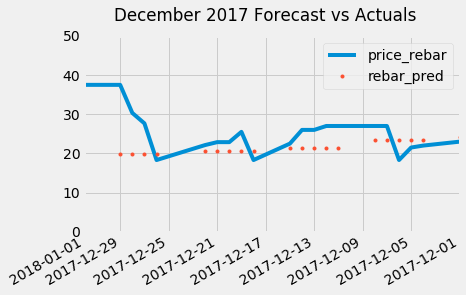

In [332]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
rebar_all[['price_rebar','rebar_pred']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='12-01-2017', upper='01-01-2018')
ax.set_ylim(0, 50)
plot = plt.suptitle('December 2017 Forecast vs Actuals')

## Error Metrics On Test Set

In [333]:
mean_squared_error(y_true=rebar_test['price_rebar'],
                   y_pred=rebar_test['rebar_pred'])

42.64043958300478

In [334]:
mean_absolute_error(y_true=rebar_test['price_rebar'],
                   y_pred=rebar_test['rebar_pred'])

4.485856790919997

Write fucntion.
How off the predictions are, in percentage.

In [335]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [336]:
mean_absolute_percentage_error(y_true=rebar_test['price_rebar'],
                   y_pred=rebar_test['rebar_pred'])

24.589170568543864